# Model Structure Selection


Anton Akusok

<anton.akusok@arcada.fi>

Slack: `@Anton Akusok`

### Model structure

Parameters (*hyper-parameters*) that you set when creating a model at Scikit-Learn, like regularization, number of trees in random forest, etc. 

Can be literally model *structure* for deep learning with different structure of layers.

### Model structure *selection*

Finding values of these parameters that will work best on **new** data.

In [1]:
import numpy as np
np.set_printoptions(suppress=True, precision=3)

Let's make totally random data with a large number of features.

We know correct answer - random data impossible to predict.

In [2]:
X = np.random.randn(150, 5000)
y = np.random.randn(150,)

In [3]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(X, y, test_size=0.33)

## Never evaluate model on training set

We care how the model can perform on new data. 

No need to get predictions for the test data -  correct answer are already in a dataset!

In [4]:
from sklearn.linear_model import Ridge

In [5]:
model = Ridge(alpha=10, fit_intercept=False).fit(X, y)

In [6]:
model.score(X, y)

0.9999960815298591

In [7]:
model.score(X_test, y_test)

-0.062189161014465144

Question: Where is that *model structure*?

## Validation works great for a single model

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y)

In [9]:
model_v = Ridge(alpha=10, fit_intercept=False).fit(X_train, y_train)

In [10]:
model_v.score(X_val, y_val)

-0.058357433364961686

In [11]:
model.score(X_test, y_test)

-0.062189161014465144

In [12]:
%timeit -n 10 model_v.score(X_val, y_val)

1.13 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Cross-validation is a better (but slower) alternative

In [13]:
from sklearn.model_selection import cross_val_score

In [14]:
cross_val_score(model, X, y, cv=5).mean()

0.020705132359177435

In [15]:
model.score(X_test, y_test)

-0.062189161014465144

In [16]:
%timeit -n 10 cross_val_score(model, X, y, cv=5).mean()

85.3 ms ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Validation may fail on a sequence of models!

Let's combine two models: 

    1. Select 5% best features
    2. Run Ridge regression

In [17]:
from sklearn.feature_selection import SelectPercentile, f_regression

In [18]:
selector = SelectPercentile(f_regression, percentile=5).fit(X, y)

In [19]:
X_best = selector.transform(X)
X_test_best = selector.transform(X_test)

In [20]:
model_best_features = Ridge(alpha=10, fit_intercept=False).fit(X_best, y)

In [21]:
cross_val_score(model_best_features, X_best, y, cv=5).mean()

0.8789683367746453

In [22]:
model_best_features.score(X_test_best, y_test)

-0.24060168453991881

## What just happened?

Selection process leaked information from outputs **y** back to the whole training dataset **X**, by selecting the best features of **X** that match **y**.

Now **X** and **y** are not independent anymore, and cross-validation produces wrong result.

![cv](img/pipe-preprocessing.png)

Correct way splits data further, with separate validation sets for each model (in our case, *SelectPercentile* and *Ridge*).

This would be too boring to code manually...

# The Pipeline

### Correct validation for multi-step models

Also simplifies coding with multiple steps in one model.

![pipe](img/pipeline.png)

In [23]:
from sklearn.pipeline import make_pipeline

In [24]:
complex_model = make_pipeline(
    SelectPercentile(f_regression, percentile=5),
    Ridge(alpha=10, fit_intercept=False)
)

In [25]:
cross_val_score(complex_model, X, y, cv=5).mean()

-0.0195997008072889

## Pipeline behaves like any other model

In [26]:
complex_model.fit(X, y)
complex_model.score(X_test, y_test)

-0.24060168453991881

## Two ways to make pipelines

In [27]:
from sklearn.pipeline import make_pipeline, Pipeline

In [28]:
pipe_A = make_pipeline(SelectPercentile(f_regression, percentile=5), 
                       Ridge(alpha=10, fit_intercept=False))

In [29]:
pipe_B = Pipeline(
    steps = [
        ('preprocessing', SelectPercentile(f_regression, percentile=5)),
        ('regression', Ridge(alpha=10, fit_intercept=False))
    ]
)

## Looking down the pipe

Pipelines made of Scikit-Learn models.

You can access models by index `.steps()[0]` or by name `.named_steps['ridge']`.

Default name is lowercase class name.

In [30]:
pipe_B.named_steps["regression"]

Ridge(alpha=10, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [31]:
pipe_A.steps[1]

('ridge', Ridge(alpha=10, copy_X=True, fit_intercept=False, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001))

## Accessing model attributes in a pipeline

In [32]:
pipe_B.named_steps['regression'].alpha

10

In [33]:
pipe_A.steps[1][1].alpha

10

# Model Structure Selection  (finally)

## == GridSearchCV on Pipelines

## What is a Grid?

Model parameters are not independent - they work in a combination.

Parameter evaluation need to check combination of parameters. A model will be tested on every combination of your parameters, like on every node of a parameter **grid**.

In [34]:
grid_params = [{
    'preprocessing__percentile': [1, 5, 25],
    'regression__alpha': [0.01, 0.1, 1, 10, 100]
}]

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
MSS = GridSearchCV(pipe_B, grid_params, cv=3)
_ = MSS.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## GridSearchCV evaluates every combination of parameters

In [37]:
MSS.cv_results_["mean_test_score"]

array([-0.627, -0.592, -0.39 , -0.113, -0.014, -0.003, -0.003, -0.003,
       -0.003, -0.005,  0.009,  0.009,  0.009,  0.009,  0.008])

In [38]:
MSS.cv_results_["params"]

[{'preprocessing__percentile': 1, 'regression__alpha': 0.01},
 {'preprocessing__percentile': 1, 'regression__alpha': 0.1},
 {'preprocessing__percentile': 1, 'regression__alpha': 1},
 {'preprocessing__percentile': 1, 'regression__alpha': 10},
 {'preprocessing__percentile': 1, 'regression__alpha': 100},
 {'preprocessing__percentile': 5, 'regression__alpha': 0.01},
 {'preprocessing__percentile': 5, 'regression__alpha': 0.1},
 {'preprocessing__percentile': 5, 'regression__alpha': 1},
 {'preprocessing__percentile': 5, 'regression__alpha': 10},
 {'preprocessing__percentile': 5, 'regression__alpha': 100},
 {'preprocessing__percentile': 25, 'regression__alpha': 0.01},
 {'preprocessing__percentile': 25, 'regression__alpha': 0.1},
 {'preprocessing__percentile': 25, 'regression__alpha': 1},
 {'preprocessing__percentile': 25, 'regression__alpha': 10},
 {'preprocessing__percentile': 25, 'regression__alpha': 100}]

## Convert results into printable form

In [39]:
import pandas as pd

In [40]:
grid_params

[{'preprocessing__percentile': [1, 5, 25],
  'regression__alpha': [0.01, 0.1, 1, 10, 100]}]

In [41]:
MSS.param_grid

[{'preprocessing__percentile': [1, 5, 25],
  'regression__alpha': [0.01, 0.1, 1, 10, 100]}]

In [42]:
y_axis = MSS.param_grid[0]['preprocessing__percentile']
x_axis = MSS.param_grid[0]['regression__alpha']

heatmap = pd.DataFrame(index=y_axis, columns=x_axis, dtype=np.float)
heatmap = heatmap.fillna(0)  # remember Pandas operations *return a copy*

In [43]:
heatmap

,0.01,0.10,1.00,10.00,100.00
1,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0


In [44]:
scores = MSS.cv_results_["mean_test_score"]
percentile = MSS.cv_results_["param_preprocessing__percentile"]
alphas = MSS.cv_results_["param_regression__alpha"]

for p,a,value in zip(percentile, alphas, scores):
    heatmap.loc[p, a] = value

In [45]:
heatmap

,0.01,0.10,1.00,10.00,100.00
1,-0.627290,-0.592345,-0.390431,-0.112872,-0.013612
5,-0.003047,-0.003042,-0.003002,-0.002736,-0.004657
25,0.009178,0.009177,0.009169,0.009088,0.008250


In [46]:
import seaborn as sn
%matplotlib inline

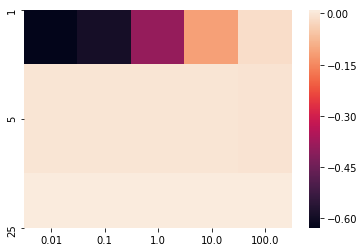

In [47]:
sn.heatmap(heatmap)

## How to find a nice colormap?

Give gibberish, read error message! :D

In [48]:
sn.heatmap(heatmap, cmap="Ö")

ValueError: Colormap Ö is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

Text(0.5, 15.0, 'Ridge alpha')

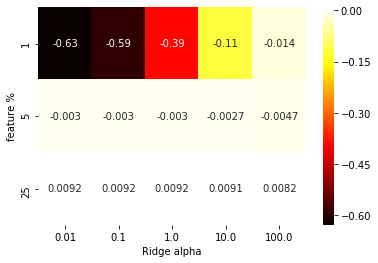

In [49]:
plot = sn.heatmap(heatmap, cmap="hot", annot=True)
plot.set_ylim([3, 0])
plot.set_ylabel("feature %")
plot.set_xlabel("Ridge alpha")

## Let's print runtimes, for instance...

In [50]:
times = MSS.cv_results_["mean_fit_time"]
percentile = MSS.cv_results_["param_preprocessing__percentile"]
alphas = MSS.cv_results_["param_regression__alpha"]

runtimes = heatmap.copy()
for p,a,value in zip(percentile, alphas, times):
    runtimes.loc[p, a] = value

Text(0.5, 15.0, 'Ridge alpha')

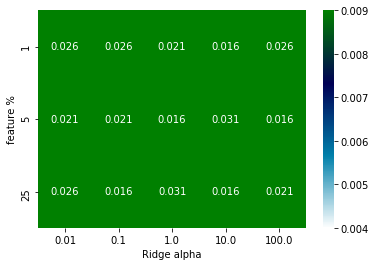

In [51]:
plot = sn.heatmap(runtimes, cmap="ocean_r", vmin=0.004, vmax=0.009, annot=True)
plot.set_ylim([3, 0])
plot.set_ylabel("feature %")
plot.set_xlabel("Ridge alpha")

## Grid search with more than 2 parameters

### Still printing only 2 at a time

Also, let's use a real dataset

In [52]:
from sklearn.datasets import fetch_20newsgroups_vectorized

In [53]:
news = fetch_20newsgroups_vectorized(subset="train")
X = news["data"]
y = news["target"]

Let's limit training size to 1000 samples, for speed

In [54]:
Xt, X_val, yt, y_val = train_test_split(X, y, train_size=1000)

In [55]:
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression

In [56]:
kpca = KernelPCA(n_components=5, kernel="cosine")
logreg = LogisticRegression(penalty="l2", C=0.1)

In [57]:
pipe = Pipeline(
    steps = [
        ('pca', kpca),
        ('classifier', logreg)
    ]
)

In [58]:
grid_params = [{
    'pca__n_components': [1, 5, 25],
    'pca__kernel': ["cosine", "linear", "rbf", "sigmoid", "poly"],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}]

In [59]:
GCV = GridSearchCV(pipe, grid_params, cv=5, n_jobs=4, verbose=10)

In [64]:
GCV.fit(Xt, yt)

Fitting 5 folds for each of 105 candidates, totalling 525 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   14.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   18.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   22.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   24.6s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   26.7s
[Parallel(

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='cosine',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=5,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('classifier',
               

Note! If you interrupt a parallel run, Jupyter notebook may break.

This is normal, just restart it.

In [65]:
GCV.best_params_

{'classifier__C': 1000, 'pca__kernel': 'cosine', 'pca__n_components': 25}

In [66]:
GCV.best_score_

0.267

In [67]:
GCV.score(X_val, y_val)

0.25344192359899165

## Beware the runtime of GridSearchCV!

### Number of models = CV * len(grid1) * len(grid2) * len(grid3) * len(grid4) * ...

Our model count is:

5 (cv) * 3 (n_components) * 5 (kernels) * 7 (C) = 525 models!

## Let's refine our Model Structure!

First, let's print current parameter values and their scores

In [68]:
params = ["pca__n_components", "pca__kernel", "classifier__C"]

In [69]:
p = params[0]
q = params[1]

In [70]:
y_axis = GCV.param_grid[0][p]
y_index = GCV.cv_results_["param_" + p]

x_axis = GCV.param_grid[0][q]
x_index = GCV.cv_results_["param_" + q]

heatmap = pd.DataFrame(index=y_axis, columns=x_axis, dtype=np.float)
heatmap = heatmap.fillna(0)  # initialize with zeros

In [72]:
scores = GCV.cv_results_["mean_test_score"]

for ix, iy, value in zip(x_index, y_index, scores):
    heatmap.loc[iy, ix] += value
    print(ix, iy, value)

cosine 1 0.068
cosine 5 0.068
cosine 25 0.068
linear 1 0.068
linear 5 0.068
linear 25 0.068
rbf 1 0.068
rbf 5 0.068
rbf 25 0.068
sigmoid 1 0.068
sigmoid 5 0.068
sigmoid 25 0.068
poly 1 0.068
poly 5 0.068
poly 25 0.068
cosine 1 0.082
cosine 5 0.089
cosine 25 0.094
linear 1 0.082
linear 5 0.089
linear 25 0.094
rbf 1 0.068
rbf 5 0.068
rbf 25 0.068
sigmoid 1 0.068
sigmoid 5 0.068
sigmoid 25 0.068
poly 1 0.068
poly 5 0.068
poly 25 0.068
cosine 1 0.11
cosine 5 0.12
cosine 25 0.138
linear 1 0.11
linear 5 0.12
linear 25 0.138
rbf 1 0.068
rbf 5 0.068
rbf 25 0.068
sigmoid 1 0.068
sigmoid 5 0.068
sigmoid 25 0.068
poly 1 0.068
poly 5 0.068
poly 25 0.068
cosine 1 0.1
cosine 5 0.14
cosine 25 0.207
linear 1 0.1
linear 5 0.14
linear 25 0.207
rbf 1 0.068
rbf 5 0.068
rbf 25 0.068
sigmoid 1 0.068
sigmoid 5 0.068
sigmoid 25 0.068
poly 1 0.068
poly 5 0.068
poly 25 0.068
cosine 1 0.103
cosine 5 0.142
cosine 25 0.259
linear 1 0.103
linear 5 0.142
linear 25 0.259
rbf 1 0.068
rbf 5 0.068
rbf 25 0.068
sigmoid 1

In [ ]:
heatmap

In [ ]:
plot = sn.heatmap(heatmap, cmap="hot", annot=True)
plot.set_ylim([len(heatmap), 0])
plot.set_ylabel(p)
plot.set_xlabel(q)

## Now let's check *n_components* versus *classifier_C*

In [ ]:
p = params[0]
m = params[1]  # missing here!
q = params[2]

In [ ]:
y_axis = GCV.param_grid[0][p]
y_index = GCV.cv_results_["param_" + p]

x_axis = GCV.param_grid[0][q]
x_index = GCV.cv_results_["param_" + q]

heatmap = pd.DataFrame(index=y_axis, columns=x_axis, dtype=np.float)
heatmap = heatmap.fillna(0)  # initialize with zeros

In [ ]:
scores = GCV.cv_results_["mean_test_score"]

for ix, iy, value in zip(x_index, y_index, scores):
    heatmap.loc[iy, ix] += value

In [ ]:
plot = sn.heatmap(heatmap, cmap="hot", annot=True)
plot.set_ylim([len(heatmap), 0])
plot.set_ylabel(p)
plot.set_xlabel(q)

Best results *in the corner* - optimal parameters are outside our test range.

We should continue the search...

## Now that we found better parameters, let's update the parameter grid

In [ ]:
grid_params2 = [{
    'pca__n_components': [25, 50, 100, 200, 400],
    'pca__kernel': ["cosine", "linear"],
    'classifier__C': [1E2, 1E3, 1E4, 1E5]
}]

In [ ]:
GCV2 = GridSearchCV(pipe, grid_params2, cv=5, n_jobs=4, verbose=10)

In [ ]:
GCV2.fit(Xt, yt)

## ... and check the performance again

In [ ]:
p = params[2]
q = params[0]

In [ ]:
y_axis = GCV2.param_grid[0][p]
y_index = GCV2.cv_results_["param_" + p]

x_axis = GCV2.param_grid[0][q]
x_index = GCV2.cv_results_["param_" + q]

heatmap = pd.DataFrame(index=y_axis, columns=x_axis, dtype=np.float)
heatmap = heatmap.fillna(0)  # initialize with zeros

In [ ]:
scores = GCV2.cv_results_["mean_test_score"]

for ix, iy, value in zip(x_index, y_index, scores):
    heatmap.loc[iy, ix] += value

In [ ]:
plot = sn.heatmap(heatmap, cmap="hot", annot=True)
plot.set_ylim([len(heatmap), 0])
plot.set_ylabel(p)
plot.set_xlabel(q)

## Finally we see the end of our search!

### Kernel reports exactly the same results - it does not matter
### Regularization *C* has the highest value *inside* our plot - it's the best one

### **C = 1000** seems to be best point, let's improve it a bit more

### *kernel* does not matter, we will use only one

In [ ]:
grid_params3 = [{
     # cannot be more than nr of training samples
    'pca__n_components': [400, 500, 600, 700], 
    'pca__kernel': ["linear"],
    'classifier__C': [700, 1000, 1200, 1700]
}]

In [ ]:
# note *error_score* - our code will fail on some params, let's let it continue execution anyway
GCV3 = GridSearchCV(pipe, grid_params3, cv=5, n_jobs=4, verbose=10)

In [ ]:
GCV3.fit(Xt, yt)

## ... and check the performance again

In [ ]:
p = params[2]
q = params[0]

In [ ]:
y_axis = GCV3.param_grid[0][p]
y_index = GCV3.cv_results_["param_" + p]

x_axis = GCV3.param_grid[0][q]
x_index = GCV3.cv_results_["param_" + q]

heatmap = pd.DataFrame(index=y_axis, columns=x_axis, dtype=np.float)
heatmap = heatmap.fillna(0)  # initialize with zeros

In [ ]:
scores = GCV3.cv_results_["mean_test_score"]

for ix, iy, value in zip(x_index, y_index, scores):
    heatmap.loc[iy, ix] += value

In [ ]:
plot = sn.heatmap(heatmap, cmap="hot", annot=True)
plot.set_ylim([len(heatmap), 0])
plot.set_ylabel(p)
plot.set_xlabel(q)

## Cannot increase *n_components* futher, so that's the best performance

In [ ]:
GCV3.score(X_val, y_val)

## Best way of taking parameter range is on **logarithmic** scale!

### Bad: [1, 2, 3, 4, 5, 6]

### Good: [1, 10, 100, 1000, 10000] == [10**1, 10**2, 10**3, 10**4]

### Don't forget *really* small values!  
### [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

## Automating Model Structure Selection

If your computer idles needlessly over the weekends...

## Auto-Sklearn

https://automl.github.io/auto-sklearn/master/#

In [ ]:
import autosklearn.classification

In [ ]:
cls = autosklearn.classification.AutoSklearnClassifier()

In [ ]:
cls.fit(X, y)

In [ ]:
predictions = cls.predict(X_test)

## TPot

https://github.com/EpistasisLab/tpot

Genetic Algorithm - creates a population of ML methods with some hyperparameters. Good methods breed and exchange good parameter values. Converges to the best method with the best parameters over time.

![tp](img/tpot-logo.jpg)

## Faster GridSearchCV on a cluster

### with Dask

## Dask-searchcv

Only need to replace the import line. Ofc more complicated if you want a real cluster.

https://dask-searchcv.readthedocs.io/en/latest/

![default](img/gridsearch-default.png)

![dask](img/gridsearch-dask.png)